In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
import pandas as pd
import random
import os
import numpy as np

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn # 신경망들이 포함됨
import torch.optim as optim # 최적화 알고리즘들이 포함됨
import torch.nn.init as init # 텐서에 초기값을 줌

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed_everything(37) # Seed 고정

In [37]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LG Aimers Dacon/open/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/LG Aimers Dacon/open/test.csv")

# data에서 모든 값이 결측치인 X 삭제

train = train_df.copy()

null = train.isnull().sum()
null = null.to_frame().transpose()
Xs = null.columns[6:]
Nan_list = []

for x in Xs:
  if float(null[x]) == len(train):
    Nan_list.append(x)

train.drop(Nan_list, axis = 1, inplace = True)

# test = test_df.copy()
# test.drop(Nan_list, axis = 1, inplace = True)

/usr/local/lib/python3.8/dist-packages/matplotlib/axes/_axes.py:7592: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


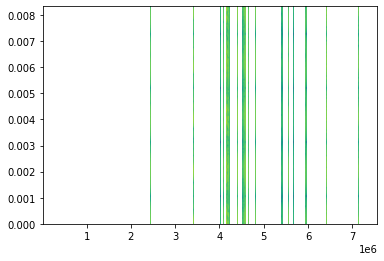

In [38]:
# 시계열 푸리에 변환
# https://stackoverflow.com/questions/22971669/time-series-analysis-with-fourier-or-maybe-other-method-in-python

import time
import matplotlib.pyplot as plt

example1 = train['TIMESTAMP']

# convert time stamps to seconds (of UNIX time):
tt_sec = np.array([int(time.mktime(time.strptime(e,"%Y-%m-%d %H:%M"))) for e in example1])
tt = (tt_sec - tt_sec[0]) // 60  # convert to minutes starting at 0

xx = np.zeros(max(tt) + 1) # make sampled array with peaks at time stamps
xx[tt] = 1 

# make spectrogram:
fg = plt.figure(1)
fg.clf()
ax = fg.add_subplot(1, 1, 1)

ax.specgram(xx, Fs=1./60)  # spectogram => tune the parameters
fg.canvas.draw()  # do the drawing

plt.show()  # enter interactive loop


In [39]:
train["TIMESTAMP"] = tt

In [40]:
# 데이터 로드
x = train.drop(columns=['PRODUCT_ID', 'Y_Class', 'Y_Quality'])
x = x.fillna(0)

y = train['Y_Class']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,)
# x_test = test_df.drop(columns=['PRODUCT_ID'])
# x_test = x_test.fillna(0)

# qualitative to quantitative
qual_col = ['LINE', 'PRODUCT_CODE']

for i in qual_col:
    le = LabelEncoder()
    le = le.fit(x_train[i])
    x_train[i] = le.transform(x_train[i])
    
    for label in np.unique(x_test[i]): 
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    x_test[i] = le.transform(x_test[i]) 

In [41]:
# 변형 객체 생성
minmax_scaler = MinMaxScaler()

# 훈련데이터의 모수 분포 저장
minmax_scaler.fit(x_train)

# 훈련 데이터 스케일링
x_train_scaled = minmax_scaler.transform(x_train)

# 테스트 데이터의 스케일링
x_test_scaled = minmax_scaler.transform(x_test)

In [44]:
print(f"x_train 크기 : {x_train.shape}")
print(f"x_test 크기 : {x_test.shape}")
print(f"y_train 크기 : {y_train.shape}")
print(f"y_test 크기 : {y_test.shape}")

x_train 크기 : (478, 2796)
x_test 크기 : (120, 2796)
y_train 크기 : (478,)
y_test 크기 : (120,)


In [68]:
reshaped_x_train = np.array(x_train)
reshaped_x_test = np.array(x_test)
# reshaped_x_train.shape # (478, 2796)
seq = 12
reshaped_x_train = reshaped_x_train.reshape(reshaped_x_train.shape[0], seq, 233)
reshaped_x_test = reshaped_x_test.reshape(reshaped_x_test.shape[0], seq, 233)

In [86]:
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.backend as K
from keras.callbacks import EarlyStopping

K.clear_session()
model = Sequential() # Sequeatial Model
model.add(LSTM(20, input_shape=(seq, 233))) # (timestep, feature)
model.add(Dense(1)) # output = 0/1/2
model.compile(loss='mean_squared_error', optimizer='adam')

# model.summary()

In [106]:
batch_size = 30
learning_rate = 0.0002
num_epoch = 60

In [107]:
early_stop = EarlyStopping(monitor='loss', patience=20, verbose=1)

model.fit(reshaped_x_train, y_train, epochs=num_epoch,
          batch_size=batch_size, verbose=1, callbacks=[early_stop])

Epoch 1/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2906
Epoch 2/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2895
Epoch 3/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2896
Epoch 4/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2871
Epoch 5/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2895
Epoch 6/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2869
Epoch 7/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2870
Epoch 8/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2880
Epoch 9/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2881
Epoch 10/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2868
Epoch 11/100
48/48 [==============================] - 0s 9ms/step - loss: 0.2875
Epoch 12/100
48/48 [==============================] - 0s 8ms/step - loss: 0.2867
Epoch 13/100
48/48 [=================

In [108]:
y_pred = model.predict(reshaped_x_test)
# print(y_pred)

4/4 [==============================] - 0s 5ms/step


In [109]:
preds = np.array([int(pred)for pred in y_pred])

In [110]:
from sklearn.metrics import *

accuracy = round((accuracy_score(y_test, preds)*100), 2)
f1_score = round((f1_score(y_test, preds, average = "macro")*100), 2)

In [105]:
print(f"accuracy : {accuracy}")
print(f"f1_score : {f1_score}")

accuracy : 61.67
f1_score : 38.27


In [99]:
# batch = 30, epoch = 60, patience = 20 -> accuracy : 69.17, f1_score : 40.95
# batch = 30, epoch = 100, patience = 20 -> accuracy : 62.5, f1_score : 38.79
# batch = 30, epoch = 80, patience = 20 -> accuracy : 61.67, f1_score : 38.27
# batch = 10, epoch = 100, patience = 20 -> accuracy : 61.67, f1_score : 38.27